In [1]:
'''
Data mining project with Katie Wu and Franco Lombardi
Oct 2017
Analyzing 2015 SEP gree taxis in NYC
'''

import findspark
findspark.init()
import pyspark 
from pyspark import SparkContext

In [2]:
config = pyspark.SparkConf().set('spark.executor.memory', '512M').set('spark.cores.max', '4')\
            .set('spark.port.maxRetries','200') 
sc = pyspark.SparkContext(appName="Project 1", master='spark://polyp1:7077',conf = config )

In [3]:
dataHeader = sc.textFile("/scratch/ISE495/2017_project_01/header.txt")
print dataHeader.collect()

[u'VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type']


In [4]:

data = sc.textFile("/scratch/ISE495/2017_project_01/green_tripdata_2015-09.csv")
#data = sc.textFile("/scratch/ISE495/2017_project_01/green_tripdata_2015-09_small.csv")

In [5]:
#TASK 1.1: How many columns and rows does the data file have?

#Decided to find the number of columns by counting the number of header titles
def headerSplit(e):
    e = e.split(',')
    return e
dataHeader_RDD = dataHeader.map(headerSplit)
header =  dataHeader_RDD.take(1)[0]
print "The number of columns is", len(header),"."
#To find the number of rows
print "The number of rows is", data.count(), "."

The number of columns is 21 .
The number of rows is 1494926 .


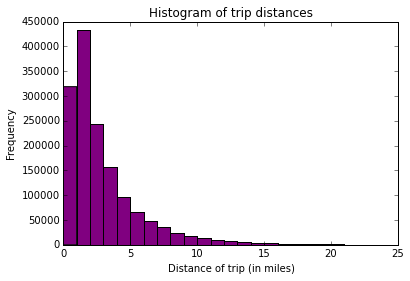

In [6]:
#TASK 1.2: Plot histogram of trip distances
def orgData(e):
    e = e.split(',')
    return e
splitData = data.map(orgData)
def tripDist(e):
    return float(e[10])
distances_RDD = splitData.map(tripDist).sortBy(lambda l: -l)
distances = distances_RDD.take(data.count())
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
x = distances
plt.hist(x, bins = [x for x in range(25)], color = 'purple')
plt.ylabel('Frequency')
plt.xlabel('Distance of trip (in miles)')
plt.title('Histogram of trip distances')
#Ignored outliers (points with distances greater than 25)



    

Hour: 	Average Distance
------------------------
0:	3.1152760654 miles
1:	3.01734718167 miles
2:	3.04617559957 miles
3:	3.21294532238 miles
4:	3.52655502573 miles
5:	4.1334742515 miles
6:	4.05514889487 miles
7:	3.28439444471 miles
8:	3.04844958874 miles
9:	2.99910522837 miles
10:	2.9444823206 miles
11:	2.9120154602 miles
12:	2.90306477831 miles
13:	2.87829444821 miles
14:	2.86430427217 miles
15:	2.85703999892 miles
16:	2.77985156082 miles
17:	2.6791138579 miles
18:	2.65322206797 miles
19:	2.71559688374 miles
20:	2.77705171559 miles
21:	2.99918861144 miles
22:	3.18539354229 miles
23:	3.19153794097 miles


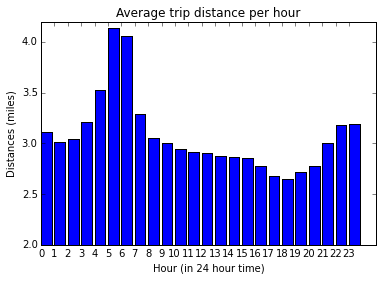

In [140]:
#TASK 3: Report mean trip distance grouped by pick-up hour of day
def pickupTime(e):
    timeStamp = e[1].split(' ')
    hour = timeStamp[1].split(':')[0]
    return [int(hour),float(e[10])]

pickupTimes = splitData.map(pickupTime)     

distancesByHour = {}
for i in range(24):
    distancesByHour[i] = (pickupTimes.filter(lambda l: l[0] == i).map(lambda l: l[1]).sum())/pickupTimes.filter(lambda l: l[0] == i).count()

print "Hour: " + '\t' + "Average Distance"
print '------------------------'
for i in range(24):
    print str(i) + ":" + '\t' + str(distancesByHour[i]) + " miles"

hours = [x for x in range(24)]
distByHour = [distancesByHour[i] for i in range(24)]

plt.bar(hours, distByHour)

axes = plt.gca()
axes.set_ylim([2.0,4.2])
plt.xticks(hours, hours)
plt.ylabel('Distances (miles)')
plt.xlabel('Hour (in 24 hour time)')
plt.title('Average trip distance per hour')
 
plt.show()

In [221]:
#TASK 4: Provide a count of how many transactions terminate at one of the NYC area airports 
#Find the average fair, and any other interesting characteristics of these trips

#Laguardia: 40.7769° N, 73.8740° (Acceptable range (based on Google Map): 40.769 - 40.78, 73.88 - 73.856)
#JFK: 40.6413° N, 73.7781° W (Acceptable range (based on Google Map): 40.66 - 40.63, 73.82 - 73.75)

def terminateAtAirport(e):
    longitude = float(e[7])
    lattitude = float(e[8])
    if ((longitude <= -73.856 and longitude >= -73.88) and (lattitude >= 40.769 and lattitude <= 40.78)) or ((longitude <= -73.75 and longitude >= -73.82) and (lattitude >= 40.63 and lattitude <= 40.66)):
        return True
    else:
        return False
    
airportTrips = splitData.filter(terminateAtAirport)

def distanceTrip(e):
    return float(e[10])

totDistAir = airportTrips.map(distanceTrip).sum()
totTripsAir = float(airportTrips.count())
avDistAir = totDistAir/totTripsAir

totDist = splitData.map(distanceTrip).sum()
totTrips = float(splitData.count())
avDist = totDist/totTrips

def fare(e):
    return float(e[11])

totFare = airportTrips.map(fare).sum()
avFare = totFare/totTripsAir

print "There are", totTripsAir, "trips to the airport (Laguardia or JFK)."


print "The average fare to either Laguardia or JFK is: $", "%.2f" % avFare

print "Another interesting fact (which makes sense given the airport dropoff) is that the average distance for these trips is", avDistAir, "miles."

print "This is compared to the average distance for all trips of", avDist, "miles."

#about the number of passengers 
p1 = airportTrips.filter(lambda l: l[9] == '1' or l[9] == '2').count()
oneP = float(p1)/float(totTripsAir)
print '{0:.2%}'.format(oneP) + ' of to the airport trips have 1  or 2 passengers'

#about tips 
def Tips(e): 
    return float(e[14])
def addT(a, b): 
    return a + b
def NoTerminateAtAirport(e):
    longitude = float(e[7])
    lattitude = float(e[8])
    if ((longitude <= -73.856 and longitude >= -73.88) and (lattitude >= 40.769 and lattitude <= 40.78)) or ((longitude <= -73.75 and longitude >= -73.82) and (lattitude >= 40.63 and lattitude <= 40.66)):
        return False
    else:
        return True
nonAirport = splitData.filter(NoTerminateAtAirport)
NontipT = nonAirport.map(Tips).reduce(addT)
AirTipT = airportTrips.map(Tips).reduce(addT)
avgNonATip = NontipT/(nonAirport.count())
avgATip = AirTipT/totTripsAir
Tipdifference = avgATip - avgNonATip
print 'The average tips for trips to the airport is $', Tipdifference, ' more than non airport trips.'



There are 31117.0 trips to the airport (Laguardia or JFK).
The average fare to either Laguardia or JFK is: $ 29.55
Another interesting fact (which makes sense given the airport dropoff) is that the average distance for these trips is 9.39709419288 miles.
This is compared to the average distance for all trips of 2.96814085112 miles.
91.66% of to the airport trips have 1  or 2 passengers
The average tips for trips to the airport is 2.77664500907  more than non airport trips


In [223]:
def tripFromAirport(e): 
    longitude = float(e[5])
    lattitude = float(e[6])
    if ((-73.88 <= longitude <= -73.856) and (40.769 <= lattitude <= 40.78)) or \
    ((-73.82 <= longitude <= -73.75) and (40.63 <= lattitude <= 40.66)):
        return [e[9], e[14], e[18], True, e[10]] #passengerCount, tip, totalPayment, airportTrip, distance 
    else: 
        return [e[9], e[14], e[18], False, e[10]]
fromAirport = splitData.map(tripFromAirport).filter(lambda l: l[3] == True)
print 'There are', fromAirport.count(), 'trips from the airport.'
totalAir = fromAirport.count() + totTripsAir

print 'Only', '{0:.2%}'.format(float(fromAirport.count())/totalAir), ' of the airport related trips are from the airport.'


There are 716 trips from the airport
Only 2.25%  of the airport related trips are from the airport


In [147]:
#TASK 5: Do two clusterings on pick-up and drop-off locations respectively
#Choose a proper number of clusters k and report the centroids. 
#Is there much difference between centroids for pick-up and drop-off? Note: do not set the maximal k too
#large in your code. k from 2 to 10 ~ 20 should be enough to try.
from pyspark.mllib.clustering import KMeans, KMeansModel
from math import sqrt

def pickupLoc(e):
    return [float(e[5]), float(e[6])]

pickups = splitData.map(pickupLoc).filter(lambda l: l[0] != 0 and l[1] != 0)

ksPickup = [i for i in range(2,21)]
erPickup = []
for k in ksPickup:
    clustersP = KMeans.train(pickups, k, maxIterations=10, initializationMode="random")
    def error(point):
        center = clustersP.centers[clustersP.predict(point)]
        return sqrt(sum([x**2 for x in (point - center)]))
    WSSEEPickups = pickups.map(error).reduce(lambda x, y: x + y)
    erPickup.append(WSSEEPickups)

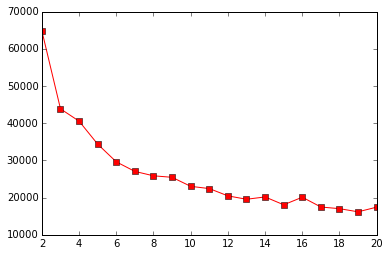

In [148]:
plt.plot(ksPickup,erPickup,'rs-')

In [149]:
def dropoffLoc(e):
    return [float(e[7]), float(e[8])]

dropoffs = splitData.map(dropoffLoc).filter(lambda l: l[0] != 0 and l[1] != 0)

ksDropoff = [i for i in range(2,21)]
erDropoff = []
for k in ksDropoff:
    clustersD = KMeans.train(dropoffs, k, maxIterations=10, initializationMode="random")
    def error(point):
        center = clustersD.centers[clustersD.predict(point)]
        return sqrt(sum([x**2 for x in (point - center)]))
    WSSEEDropoffs = dropoffs.map(error).reduce(lambda x, y: x + y)
    erDropoff.append(WSSEEDropoffs)

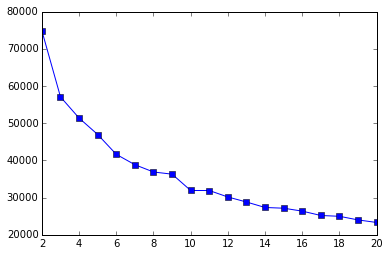

In [150]:
plt.plot(ksDropoff,erDropoff,'bs-')

In [151]:
#optimal k for pickup is 11
#optimal k for dropoff is 10
clustersPickup = KMeans.train(pickups, 11, maxIterations=10, initializationMode="random")
clustersDropoff = KMeans.train(dropoffs, 10, maxIterations=10, initializationMode="random")
print "Pickup clusters:"
for i in clustersPickup.centers:
    print i
print "Dropoff clusters:"
for i in clustersDropoff.centers:
    print i

Pickup clusters:
[-73.99068025  40.67044739]
[-73.95843153  40.60614414]
[-73.94492346  40.67851288]
[-73.92288186  40.76024145]
[-73.93527636  40.83147644]
[-73.83462791  40.72603715]
[-73.88546884  40.74610696]
[-73.98344347  40.69098125]
[-73.94912012  40.80206022]
[-73.88101856  40.85458562]
[-73.9547345   40.71917719]
Dropoff clusters:
[-73.93894134  40.82143279]
[-73.95347984  40.78659832]
[-73.97318888  40.74436533]
[-73.80586363  40.70105142]
[-73.96805099  40.68362091]
[-73.97411677  40.63112142]
[-73.88523756  40.85646082]
[-73.92858049  40.69203474]
[-73.88629178  40.75250279]
[-73.99870585  40.70181865]


In [156]:
pickupLat = []
pickupLong = []
for i in clustersPickup.centers:
    pickupLong.append(i[0])
    pickupLat.append(i[1])

dropoffLat = []
dropoffLong = []
for i in clustersDropoff.centers:
    dropoffLong.append(i[0])
    dropoffLat.append(i[1])

[-73.938941341736665, -73.953479838762021, -73.973188877178572, -73.805863625998256, -73.968050991592989, -73.974116774230552, -73.885237557681293, -73.928580488778792, -73.886291783266913, -73.998705853704195]


In [158]:
import gmplot

gmap = gmplot.GoogleMapPlotter(37.428, -122.145, 16)

gmap.scatter(pickupLat, pickupLong, '#3B0B39', size=1000, marker=False)
gmap.scatter(dropoffLat, dropoffLong, '#FF69B4', size=1000, marker=False)


gmap.draw("T5.html")


In [159]:
#TASK 6: Cluster pick-up and drop-off locations. Choose a proper number of clusters k and report the centroids (you can use
#google maps to show centroids). What is the percentage of trips for each cluster? What is percentage of trips where
#pick-up and drop-off are in the same cluster? What have you learnt from this?
def pickupDropoff(e):
    return [float(e[5]), float(e[6])], [float(e[7]), float(e[8])]
pdLocs = splitData.flatMap(pickupDropoff).filter(lambda l: l[0] != 0 and l[1] != 0)

ksPD = [i for i in range(2,21)]
erPD = []
for k in ksPD:
    clustersPD = KMeans.train(pdLocs, k, maxIterations=10, initializationMode="random")
    def error(point):
        center = clustersPD.centers[clustersPD.predict(point)]
        return sqrt(sum([x**2 for x in (point - center)]))
    WSSEEPD = pdLocs.map(error).reduce(lambda x, y: x + y)
    erPD.append(WSSEEPD)


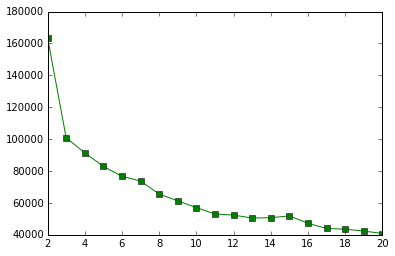

In [160]:
plt.plot(ksPD, erPD, 'gs-')

In [161]:
#optimal k for pickup/dropoff is 12
clustersPD = KMeans.train(pdLocs, 12, maxIterations=10, initializationMode="random")
print "PD cluster centers:"
for i in clustersPD.centers:
    print i

PD cluster centers:
[-73.98207193  40.68866279]
[-73.98988616  40.74320229]
[-73.93119682  40.83430488]
[-73.95430344  40.72131899]
[-73.95593963  40.62564175]
[-73.99882396  40.66366949]
[-73.94939344  40.80603446]
[-73.94659484  40.77487911]
[-73.89196639  40.75172466]
[-73.9367916   40.68311219]
[-73.82285148  40.71682073]
[-73.87728671  40.85647303]


In [162]:
pdLat = []
pdLong = []
for i in clustersPD.centers:
    pdLong.append(i[0])
    pdLat.append(i[1])

[40.688662785655652, 40.743202285836958, 40.83430487580619, 40.721318987424134, 40.625641745305479, 40.663669487251916, 40.806034458596983, 40.774879110208431, 40.75172466046071, 40.683112190008423, 40.716820728496202, 40.856473027639325]
[-73.982071930754984, -73.989886155953158, -73.931196820069204, -73.95430343516513, -73.955939630390176, -73.99882395568595, -73.949393444960606, -73.946594841709071, -73.891966391708166, -73.936791595926891, -73.822851484463428, -73.8772867063647]


In [163]:
import gmplot

gmap = gmplot.GoogleMapPlotter(37.428, -122.145, 16)

gmap.scatter(pdLat, pdLong, '#3B0B39', size=1000, marker=False)

gmap.draw("T6.html")


In [164]:
def predicted(e):
    return clustersPD.predict(e)

predictedClusters = pdLocs.map(predicted)
clust = np.zeros(12)

for i in range(12):
    clust[i] = predictedClusters.filter(lambda l: l == i).count()
print clust

# 390445.  147226.  227992.  286397.   60742.   91742.  509142.  268696.
#  455252.  248205.  200080.   99860.

[ 390445.  147226.  227992.  286397.   60742.   91742.  509142.  268696.
  455252.  248205.  200080.   99860.       0.       0.       0.       0.]


In [170]:
numPredicted = float(predictedClusters.count())
numTotal = float(data.count())
percentNoCluster = ((numTotal - numPredicted) / numTotal) * 100.0
percentPerCluster = np.zeros(12)
for i in range(12):
    percentPerCluster[i] = (float(clust[i])/numPredicted) * 100.0

print "Percent of trips without valid lattitude and longitude:", percentNoCluster
print "Then of those with valid lattitude and longitude, we found the percentages per cluster below:"
print "Cluster Number" + "\t" + "Cluster Percentage"    

for i in range(12):
    print str(i) + "\t" + str(percentPerCluster[i])+ " %"

Percent of trips without valid lattitude and longitude: -99.7275450424
Then of those with valid lattitude and longitude, we found the percentages per cluster below:
Cluster Number	Cluster Percentage
0	13.0768218277 %
1	4.93090747842 %
2	7.63593018773 %
3	9.5920361152 %
4	2.03437695824 %
5	3.0726319664 %
6	17.0522332698 %
7	8.99919250554 %
8	15.2473441604 %
9	8.31290594515 %
10	6.70109877523 %
11	3.34452081015 %


In [180]:
#considering only the trips with valid lat and long
#What is percentage of trips where pick-up and drop-off are in the same cluster?
def pickUpAndDropOff(e):
    return [[float(e[5]),float(e[6])],[float(e[7]),float(e[8])]]
def predictBoth(e):
    if clustersPD.predict(e[0]) == clustersPD.predict(e[1]):
        return True
    else:
        return False

predictsSame = splitData.map(pickUpAndDropOff).filter(predictBoth).count()

percentSame = (float(predictsSame)/numPredicted) * 100.0

print "The percentage of trips where pick-up and drop-off are in the same cluster is: ", percentSame, "%."

The percentage of trips where pick-up and drop-off are in the same cluster is:  24.8808099997 %.


In [181]:
#TASK 7: Association Rules
def where2where(e):
    pickup = ''
    dropoff = ''
    pLong = float(e[5])
    pLat = float(e[6])
    dLong = float(e[7])
    dLat = float(e[8])
    boundaryPickup = (1.323942 * pLong) + 138.669195
    if pLat > boundaryPickup:
        pickup = 'NJ'
    else:
        pickup = 'NY'
    boundaryDropoff = (1.323942 * dLong) + 138.669195
    if dLat > boundaryDropoff:
        dropoff = 'NJ'
    else:
        dropoff = 'NY'
    return [pickup+"-"+dropoff, e]

groupedPDData = splitData.map(where2where)

NYNYtraffic = groupedPDData.filter(lambda l: l[0] == 'NY-NY')
NJNJtraffic = groupedPDData.filter(lambda l: l[0] == 'NJ-NJ')
NYNJtraffic = groupedPDData.filter(lambda l: l[0] == 'NY-NJ')
NJNYtraffic = groupedPDData.filter(lambda l: l[0] == 'NJ-NY')

    

/usr/lib/python2.7/dist-packages/matplotlib/legend.py:611: UserWarning: Legend does not support 1480.0 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle))


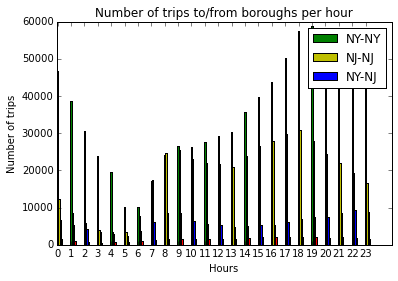

In [198]:
NYNY = np.zeros(24)
NJNJ = np.zeros(24)
NYNJ = np.zeros(24)
NJNY = np.zeros(24)


for i in range(24):
    NYNY[i] = NYNYtraffic.filter(lambda l: int(l[1][1].split(' ')[1].split(':')[0]) == i).count()
    NJNJ[i] = NJNJtraffic.filter(lambda l: int(l[1][1].split(' ')[1].split(':')[0]) == i).count()
    NYNJ[i] = NYNJtraffic.filter(lambda l: int(l[1][1].split(' ')[1].split(':')[0]) == i).count()
    NJNY[i] = NJNYtraffic.filter(lambda l: int(l[1][1].split(' ')[1].split(':')[0]) == i).count()



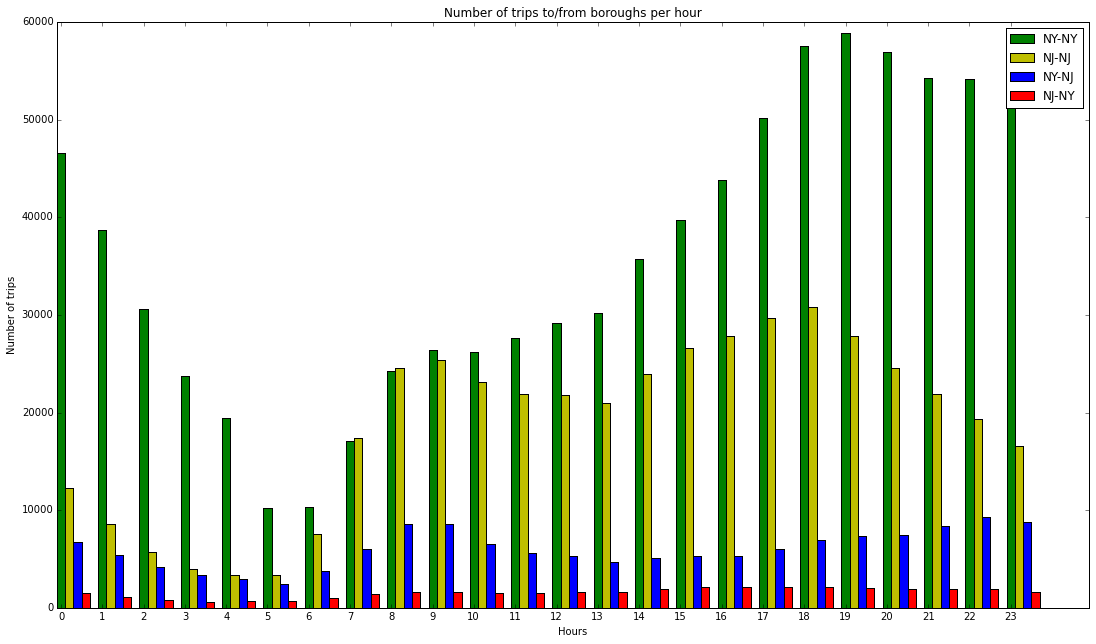

In [213]:
N = 24
ind = np.arange(24)  # the x locations for the groups
width = 0.20      # the width of the bars
fig, ax = plt.subplots()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
NYNYnum = ax.bar(ind, NYNY, width, color='g', label = 'NY-NY')
NJNJnum = ax.bar(ind + width, NJNJ, width, color='y', label = 'NJ-NJ')
NYNJnum = ax.bar(ind + (2*width), NYNJ, width, color = 'b', label = 'NY-NJ')
NJNYnum = ax.bar(ind + (3*width), NJNY, width, color = 'r', label = 'NJ-NY')
# add some text for labels, title and axes ticks
ax.set_ylabel('Number of trips')
ax.set_xlabel('Hours')
ax.set_title('Number of trips to/from boroughs per hour')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'))
plt.legend()
plt.show()

In [214]:
#FRANCO:
def groupByState(e):
    key = e[0]
    value = [float(e[1][11]),1]
    return key, value
    
#identify which state they come and go to 
FareData = groupedPDData.map(groupByState)

#print groupByState(where2where(orgData(test)))
types = ['NY-NY', "NJ-NJ", "NY-NJ" , "NJ-NY"]

FareData = FareData.reduceByKey(lambda x, y: [x[0]+y[0], x[1]+y[1]])

def compAvg(e):
    key = e[0]
    value = e[1][0]/e[1][1]
    return key, value

FareAvg = FareData.map(compAvg)

def mapSum(e):
    return e[1][0]
FareSum = FareData.map(mapSum)
FareSum = FareSum.reduce(lambda x,y: x+y)

def FarePerc(e):
    key = e[0]
    value = 100*(e[1][0]/FareSum)
    return key, value

FarePercents = FareData.map(FarePerc)

FAvg = FareAvg.collect()
FPerc = FarePercents.collect()
for i in range(4):
    print "Average Fare from", FAvg[i][0], "is $", FAvg[i][1]
    print "Percent of Fares made from", FPerc[i][0], "is", FPerc[i][1], "%"

[('NY-NJ', 21.943149052806884), ('NY-NY', 11.467664249618013), ('NJ-NJ', 10.56642849509051), ('NJ-NY', 25.013366008671532)]
Average Fare from NY-NJ is $ 21.9431490528
Percent of Fares made from NY-NJ is 16.8641755708 %
Average Fare from NY-NY is $ 11.4676642496
Percent of Fares made from NY-NY is 52.8735700207 %
Average Fare from NJ-NJ is $ 10.5664284951
Percent of Fares made from NJ-NJ is 25.3088450631 %
Average Fare from NJ-NY is $ 25.0133660087
Percent of Fares made from NJ-NY is 4.95340934542 %


In [224]:
# in NYC -> NYC, uptown <-> downtown
def uptown (e):
    if e[1][8] > e[1][6]:
        return True
    else:
        return False 

    
goingUp = NYNYtraffic.map(uptown).filter(lambda l: l == True)
goingDown = NYNYtraffic.map(uptown).filter(lambda l: l == False)

NYNYCount = NYNYtraffic.count()
goingUpCount = float(goingUp.count())
dtPercent = 1-(goingUpCount/NYNYCount)


print '{0:.2%}'.format(dtPercent)+ 'of the trips in NYC are going downtown'



['NY-NY', [u'2', u'2015-09-01 00:02:34', u'2015-09-01 00:02:38', u'N', u'5', u'-73.979484558105469', u'40.684955596923828', u'-73.97943115234375', u'40.685020446777344', u'1', u'.00', u'7.8', u'0', u'0', u'1.95', u'0', u'', u'0', u'9.75', u'1', u'2']]
[True, True, True, True, True, True, True, True, True, True]
864553 395604.0
54.24%of the trips in NYC are going downtown


In [225]:
# in NJ -> NYC, morning commute? 
# take NJ -> NYC RDD
#print NJNYtraffic.first()
#print NJNYtraffic.first()[1][1].split(' ')[1].split(':')[2]
def ptime (e): 
    time = e[1][1].split(' ')
    hour = time[1].split(':')[0]
    return [int(hour)]
#print NJNYtraffic.map(time).take(100)
NJmorning_commute = NJNYtraffic.map(ptime).filter(lambda l: 6 <= l[0] <=9)
NJevening_commute = NYNJtraffic.map(ptime).filter(lambda l: 16 <= l[0] <= 19)
NJCommuteCount = NJmorning_commute.count() + NJevening_commute.count()
NJNYCCount = float(NJNYtraffic.count() + NYNJtraffic.count())
print '{0:.2%}'.format(NJCommuteCount/NJNYCCount)+ ' of the total trips are from NJ communters'
#print NJCommuteCount, NJNYCCount


17.23%of the total trips are from NJ communters


In [228]:
# rush hour traffic 
rushHour = splitData.map(pickupTime).filter(lambda l: 7 <= l[0] <= 9 or 16 <= l[0] <= 19)
totalT = float(splitData.count())
print '{0:.2%}'.format(rushHour.count()/totalT)+ ' of the trips are during rush hours'




35.02% of the trips are during rush hours


In [229]:
print header

[u'VendorID', u'lpep_pickup_datetime', u'Lpep_dropoff_datetime', u'Store_and_fwd_flag', u'RateCodeID', u'Pickup_longitude', u'Pickup_latitude', u'Dropoff_longitude', u'Dropoff_latitude', u'Passenger_count', u'Trip_distance', u'Fare_amount', u'Extra', u'MTA_tax', u'Tip_amount', u'Tolls_amount', u'Ehail_fee', u'improvement_surcharge', u'Total_amount', u'Payment_type', u'Trip_type']


In [22]:
print splitData.take(1)

def getDay(e):
    dateTime = e[1]
    date = dateTime.split(' ')[0]
    day = int(date.split('-')[2])
    return day

days = splitData.map(getDay)
tripsPerDay = np.zeros(30)
for i in range(1,31):
    tripsPerDay[i-1] = days.filter(lambda l: l==i).count()


[[u'2', u'2015-09-01 00:02:34', u'2015-09-01 00:02:38', u'N', u'5', u'-73.979484558105469', u'40.684955596923828', u'-73.97943115234375', u'40.685020446777344', u'1', u'.00', u'7.8', u'0', u'0', u'1.95', u'0', u'', u'0', u'9.75', u'1', u'2']]


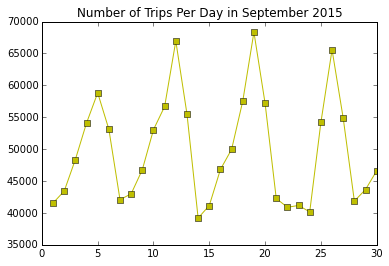

In [38]:
daysOfTheMonth = [x for x in range(1,31)]
plt.plot(daysOfTheMonth,tripsPerDay,'ys-')
plt.title("Number of Trips Per Day in September 2015")

In [35]:
def getHour(e):
    dateTime = e[1].split(' ')
    date = dateTime[0]
    day = int(date.split('-')[2])
    time = dateTime[1]
    hour = int(time.split(':')[0])
    return [day, hour]

weekends = splitData.map(getHour).filter(lambda l: l[0]==5 or l[0]==12 or l[0]==19 or l[0]==26)
weekendHours = np.zeros(24)
for i in range(24):
    weekendHours[i] = weekends.filter(lambda l: l[1] == i).count()

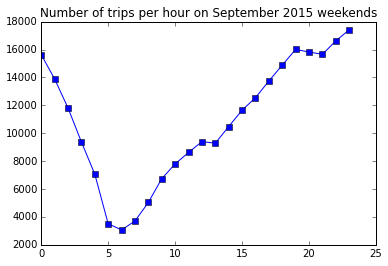

In [39]:
hoursOnTheWeekend = [x for x in range(24)]
plt.plot(hoursOnTheWeekend, weekendHours, 'bs-')
plt.title("Number of trips per hour on September 2015 weekends")

In [41]:
nonWeekends = splitData.map(getHour).filter(lambda l: l[0]!=5 and l[0]!=12 and l[0]!=19 and l[0]!=26)
nonWeekendHours = np.zeros(24)
for i in range(24):
    nonWeekendHours[i] = nonWeekends.filter(lambda l: l[1] == i).count()

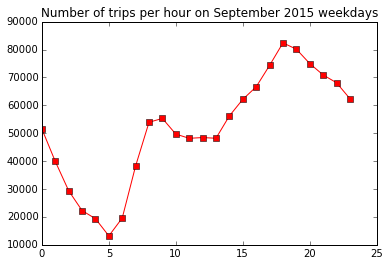

In [42]:
hoursDuringWeek = [x for x in range(24)]
plt.plot(hoursDuringWeek, nonWeekendHours, 'rs-')
plt.title("Number of trips per hour on September 2015 weekdays")

In [54]:
def amountPaid(e):
    dateTime = e[1].split(' ')
    date = dateTime[0]
    day = int(date.split('-')[2])
    amountPaid = float(e[18])
    return [day, amountPaid]

paymentByDay = splitData.map(amountPaid)

def add(a,b):
    return a+b

paymentByDayReduced = paymentByDay.reduceByKey(add)

paymentDaySorted = paymentByDayReduced.sortBy(lambda l: -l[1])
print "Most Profitable Days",
print ' '
for (a,b) in paymentDaySorted.take(10):
    print a,"\t",b

Most Profitable Days  
19 	1059257.56
12 	1015901.0
26 	994744.26
18 	885568.390001
5 	882249.42
11 	881832.760001
20 	879678.740001
13 	838903.9
27 	837646.7
4 	825679.73


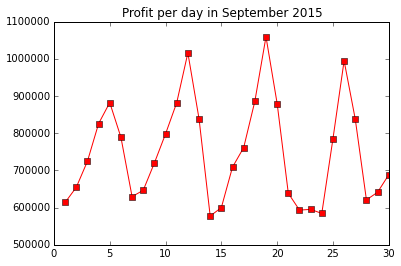

In [63]:
orderedPaymentDays = paymentByDayReduced.sortBy(lambda l: l[0])
paymentsbyDay = orderedPaymentDays.map(lambda l: l[1]).collect()
plt.plot(daysOfTheMonth,paymentsbyDay, 'rs-')
plt.title("Profit per day in September 2015")

In [8]:
'''Create 5 pickup clusters for each hour'''
from pyspark.mllib.clustering import KMeans, KMeansModel
def pickupclusters(e):
    timeStamp = e[1].split(' ')
    hour = timeStamp[1].split(':')[0]
    return [int(hour), float(e[5]), float(e[6])]

pickuplocClusters = splitData.map(pickupclusters)


def locOnly(e):
    return e[1:]

for i in range(24):
    pickupbyHour = pickuplocClusters.filter(lambda l: l[0] == i and float(l[1]) != 0 and float(l[2]) != 0).map(locOnly)
    clusters_pickup = KMeans.train(pickupbyHour, 5, maxIterations=10, initializationMode="random")
    print 'Pickup clusters hour ' + str(i) +':'
    for i in clusters_pickup.centers:
        print i 
    print ' '

Pickup clusters hour 0:
[-73.83747732  40.72925045]
[-73.9508131   40.71495446]
[-73.9045547   40.75420007]
[-73.97394395  40.67716216]
[-73.93762444  40.81696661]
 
Pickup clusters hour 1:
[-73.98076344  40.67767025]
[-73.93722211  40.68516933]
[-73.875533    40.74424627]
[-73.93661353  40.81780463]
[-73.95191477  40.72334083]
 
Pickup clusters hour 2:
[-73.93105997  40.8045697 ]
[-73.9318844   40.69162678]
[-73.97504497  40.6751784 ]
[-73.95361245  40.72126902]
[-73.87098524  40.74161089]
 
Pickup clusters hour 3:
[-73.93016361  40.69319945]
[-73.95569807  40.71911175]
[-73.88616134  40.74827046]
[-73.93508242  40.82151405]
[-73.97363568  40.67439076]
 
Pickup clusters hour 4:
[-73.89587851  40.75190846]
[-73.93290918  40.82345043]
[-73.96580121  40.67471218]
[-73.83076122  40.72283435]
[-73.95073317  40.71613625]
 
Pickup clusters hour 5:
[-73.90805217  40.84957197]
[-73.94556382  40.80854273]
[-73.86700587  40.73930122]
[-73.92056021  40.75720567]
[-73.95794167  40.69651579]
 
Pick

In [ ]:
'''plug 10am clusters onto the map'''
'''
given Pickup clusters hour 10:
[-73.92006552  40.75299758]
[-73.84642313  40.73028197]
[-73.90185753  40.85090884]
[-73.97302741  40.68498621]
[-73.94724079  40.80715293]
'''
cluster10 = [-73.92006552, 40.75299758
            , -73.84642313, 40.73028197
            , -73.90185753, 40.85090884
            , -73.97302741, 40.68498621
            , -73.94724079, 40.80715293]

lat = []
lon = []
j = 0
for j in range(10): 
    if j%2 != 0:
        lat.append(cluster10[j])
    else: 
        lon.append(cluster10[j])

gmap = gmplot.GoogleMapPlotter(37.428, -122.145, 16)
for i in range(5):
    gmap.scatter(lat, lon, '#FA8072', size=1000, marker=False)

gmap.draw("10amClusters.html")


In [13]:
'''loss from no charge trips'''
noChargeData = splitData.filter(lambda l: int(l[19]) == 3)
def add(a, b): 
    return a + b
def getDistance (e):
    return float(e[10])
nochargeNum = noChargeData.map(getDistance).filter(lambda l: l != 0).count()
nochagedis = noChargeData.map(getDistance).filter(lambda l: l != 0).reduce(add)
#print nochagedis
#NYC taxi rate in 2015: $2 initial + $0.30 per 1/5miles
loss = 2 *nochargeNum +0.30*nochagedis*5
print 'The loss cause by no charge trips in this month is', loss

The loss cause by no charge trips in this month is 24491.32


In [64]:
sc.stop()